# Self-Explaining MRI GAN

**Interpretable Brain MRI Synthesis with Grad-CAM Guided Discriminator Reasoning**

This project trains a GAN to generate realistic brain MRI images from learned data distributions.

It then applies Grad-CAM to the discriminator to visualize which anatomical regions influence its realism decisions.

The result is a self-explaining generative model that not only produces MRI-like images, but also reveals how and where the model is reasoning

**Disclaimer: Notebook is executed on Google Colab**

## Setup & Imports

Importing the necessary libraries

In [ ]:
# importing the necessary libraries

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset Loading

Loading the Dataset (directly from Kaggle)

In [ ]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


Dataset Preprocessing 

In [ ]:
class MRIDataset(Dataset):
    def __init__(self, root_dir, img_size=128):
        self.image_paths = []
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_paths.append(os.path.join(root, file))
        if len(self.image_paths) == 0:
            raise RuntimeError("No images found!")
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # -> [-1, 1]
        ])
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")
        return self.transform(img)
dataset = MRIDataset(path, img_size=128)
print("Total images:", len(dataset))

Total images: 7023


In [ ]:
# loading data as 32 images per batch
BATCH_SIZE = 32
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
batch = next(iter(loader))
print("Batch shape:", batch.shape)

Batch shape: torch.Size([32, 1, 128, 128])


## Model Architecture

Generator Class
- maps random noise to realistic MRI images
- learns skull shape, brain outline and other MRI features

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()

        # using deconvolutional layers
        # to upsample the input from low resolution noise to high resolution images
        # channels count decrease - spatial dimensions upsamples
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 8, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

Discriminator Class
- distinguishes between real images (from dataset) and fake images (generated by the Generator)
- decisions interpreted by GradCAM core

GradCAM (Gradient-weighted Class Activation Mapping)
- tells which part of image is most influenced by the model's decision
- gives a resultant heatmap based on feature extraction from discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # standard CNN's to downsample input images
        # no. of channels increases, spatial dimensions decreases
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),          # 1 input channel, outputs 64 channels, 4x4 kernel, 2 stride and a single padding
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # final classification layer
        # 512 channel feature maps, maps to 1 output channel, kernel size 8, stride of 1 and 0 padding
        self.classifier = nn.Conv2d(512, 1, 8, 1, 0)

    # says how the input image flows through the network
    def forward(self, x):
        feats = self.features(x)
        out = self.classifier(feats)
        return out.view(-1), feats

Good Adversarial Learning
- dynamic balance between discriminator loss and generator loss
- More good the Discriminator, More good the Generator tries to be


In [ ]:
def generator_loss(fake_logits):
    # generator's goal - to generate fake images close to real images
    # generator tries to fool the discriminator to believe it's fake images are real
    return F.binary_cross_entropy_with_logits(
        fake_logits, torch.ones_like(fake_logits)
    )
    
def discriminator_loss(real_logits, fake_logits):
    # distinguishes real dataset images from fake generated images
    # discriminator tries to minimize total loss
    real_loss = F.binary_cross_entropy_with_logits(
        real_logits, torch.ones_like(real_logits)
    )
    fake_loss = F.binary_cross_entropy_with_logits(
        fake_logits, torch.zeros_like(fake_logits)
    )
    return real_loss + fake_loss


Model's Sanity Check

Below 2 conditions satisfies for a good model
- fake shape resembles close to real images
- feature maps shape align with final discriminator CNN layer

In [ ]:
LATENT_DIM = 100
G = Generator(LATENT_DIM).to(device)
D = Discriminator().to(device)

z = torch.randn(4, LATENT_DIM, 1, 1).to(device)
fake = G(z)
logits, feats = D(fake)

print("Fake shape:", fake.shape)
print("Logits shape:", logits.shape)
print("Feature map shape:", feats.shape)

Fake shape: torch.Size([4, 1, 128, 128])
Logits shape: torch.Size([4])
Feature map shape: torch.Size([4, 512, 8, 8])


## Training Procedure

In [ ]:
# Defining Optimizers
LR = 2e-4
opt_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

# 40 epochs training
EPOCHS = 40
for epoch in range(EPOCHS):
    d_loss_epoch = 0
    g_loss_epoch = 0
    for real_imgs in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # ---- Train Discriminator ----
        z = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)
        fake_imgs = G(z).detach()

        real_logits, _ = D(real_imgs)
        fake_logits, _ = D(fake_imgs)

        d_loss = discriminator_loss(real_logits, fake_logits)

        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

        # ---- Train Generator ----
        z = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)
        fake_imgs = G(z)

        fake_logits, _ = D(fake_imgs)
        g_loss = generator_loss(fake_logits)

        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

    print(
        f"[Epoch {epoch+1}] "
        f"D Loss: {d_loss_epoch/len(loader):.4f} | "
        f"G Loss: {g_loss_epoch/len(loader):.4f}"
    )

Epoch 1/40: 100%|██████████| 220/220 [00:34<00:00,  6.31it/s]


[Epoch 1] D Loss: 0.4015 | G Loss: 7.5429


Epoch 2/40: 100%|██████████| 220/220 [00:35<00:00,  6.12it/s]


[Epoch 2] D Loss: 0.6308 | G Loss: 4.8346


Epoch 3/40: 100%|██████████| 220/220 [00:36<00:00,  6.07it/s]


[Epoch 3] D Loss: 0.5528 | G Loss: 5.1036


Epoch 4/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 4] D Loss: 0.5867 | G Loss: 4.1158


Epoch 5/40: 100%|██████████| 220/220 [00:35<00:00,  6.11it/s]


[Epoch 5] D Loss: 0.6210 | G Loss: 3.4866


Epoch 6/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 6] D Loss: 0.5613 | G Loss: 3.3460


Epoch 7/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 7] D Loss: 0.5482 | G Loss: 3.6356


Epoch 8/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 8] D Loss: 0.5020 | G Loss: 3.7032


Epoch 9/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 9] D Loss: 0.4987 | G Loss: 3.8006


Epoch 10/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 10] D Loss: 0.5257 | G Loss: 3.8394


Epoch 11/40: 100%|██████████| 220/220 [00:35<00:00,  6.13it/s]


[Epoch 11] D Loss: 0.4525 | G Loss: 3.8550


Epoch 12/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 12] D Loss: 0.4858 | G Loss: 4.1250


Epoch 13/40: 100%|██████████| 220/220 [00:35<00:00,  6.16it/s]


[Epoch 13] D Loss: 0.4290 | G Loss: 4.0314


Epoch 14/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 14] D Loss: 0.4807 | G Loss: 4.2009


Epoch 15/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 15] D Loss: 0.4260 | G Loss: 3.9895


Epoch 16/40: 100%|██████████| 220/220 [00:35<00:00,  6.12it/s]


[Epoch 16] D Loss: 0.4613 | G Loss: 4.1423


Epoch 17/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 17] D Loss: 0.4696 | G Loss: 4.3215


Epoch 18/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 18] D Loss: 0.3659 | G Loss: 4.0501


Epoch 19/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 19] D Loss: 0.3768 | G Loss: 4.1943


Epoch 20/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 20] D Loss: 0.3801 | G Loss: 4.2256


Epoch 21/40: 100%|██████████| 220/220 [00:35<00:00,  6.13it/s]


[Epoch 21] D Loss: 0.3862 | G Loss: 4.3110


Epoch 22/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 22] D Loss: 0.3533 | G Loss: 4.2884


Epoch 23/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 23] D Loss: 0.3868 | G Loss: 4.4423


Epoch 24/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 24] D Loss: 0.3079 | G Loss: 4.4718


Epoch 25/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 25] D Loss: 0.3409 | G Loss: 4.5240


Epoch 26/40: 100%|██████████| 220/220 [00:35<00:00,  6.12it/s]


[Epoch 26] D Loss: 0.3191 | G Loss: 4.4493


Epoch 27/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 27] D Loss: 0.3573 | G Loss: 4.4342


Epoch 28/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 28] D Loss: 0.3101 | G Loss: 4.5813


Epoch 29/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 29] D Loss: 0.2781 | G Loss: 4.6361


Epoch 30/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 30] D Loss: 0.3000 | G Loss: 4.7453


Epoch 31/40: 100%|██████████| 220/220 [00:35<00:00,  6.13it/s]


[Epoch 31] D Loss: 0.2842 | G Loss: 4.8504


Epoch 32/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 32] D Loss: 0.3701 | G Loss: 4.7974


Epoch 33/40: 100%|██████████| 220/220 [00:35<00:00,  6.12it/s]


[Epoch 33] D Loss: 0.2375 | G Loss: 4.6201


Epoch 34/40: 100%|██████████| 220/220 [00:36<00:00,  6.10it/s]


[Epoch 34] D Loss: 0.1787 | G Loss: 4.8710


Epoch 35/40: 100%|██████████| 220/220 [00:36<00:00,  6.08it/s]


[Epoch 35] D Loss: 0.3187 | G Loss: 5.0317


Epoch 36/40: 100%|██████████| 220/220 [00:35<00:00,  6.13it/s]


[Epoch 36] D Loss: 0.3597 | G Loss: 4.9917


Epoch 37/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]


[Epoch 37] D Loss: 0.1409 | G Loss: 4.7640


Epoch 38/40: 100%|██████████| 220/220 [00:35<00:00,  6.12it/s]


[Epoch 38] D Loss: 0.2626 | G Loss: 5.0010


Epoch 39/40: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


[Epoch 39] D Loss: 0.2114 | G Loss: 5.1745


Epoch 40/40: 100%|██████████| 220/220 [00:35<00:00,  6.15it/s]

[Epoch 40] D Loss: 0.2578 | G Loss: 5.2265


**Note: The Trained Generator and Discriminator models are saved and available in the trained_models folder**

## Results: Generated Images

Generate Final MRI Samples

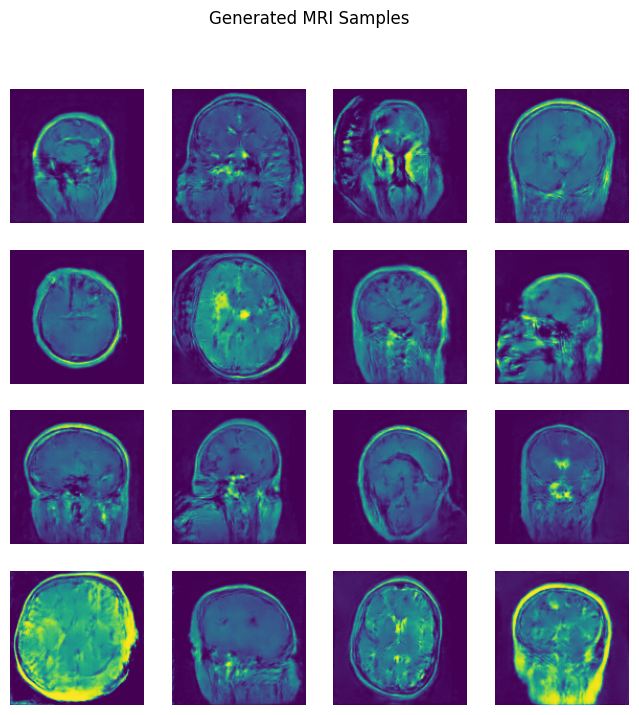

In [ ]:
G.eval()

with torch.no_grad():
    z = torch.randn(16, LATENT_DIM, 1, 1).to(device)
    samples = G(z).cpu()

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(samples[i].squeeze())
    ax.axis("off")

plt.suptitle("Generated MRI Samples")
plt.show()

**Freeze the Discriminator**

- Interpretation is the main goal, not training.
- Required for Grad-CAM, as weights need to be fixed

In [ ]:
D.eval()
for p in D.parameters():
    p.requires_grad = False

## Interpretability: Grad-CAM

GradCAM Implementation

In [ ]:
def compute_gradcam(model, x):
    x = x.requires_grad_(True)

    logits, features = model(x)          # forward
    features.retain_grad()               # Retain gradients for the features tensor
    score = logits.mean()                # realism score

    model.zero_grad()
    score.backward()                     # backward

    grads = features.grad                # d(score)/d(features)
    weights = grads.mean(dim=(2, 3), keepdim=True)

    cam = (weights * features).sum(dim=1)
    cam = torch.relu(cam)

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    cam = torch.nn.functional.interpolate(
        cam.unsqueeze(0),
        size=x.shape[2:],
        mode="bilinear",
        align_corners=False
    )

    return cam.squeeze().detach()

GradCAM on Generated MRI

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


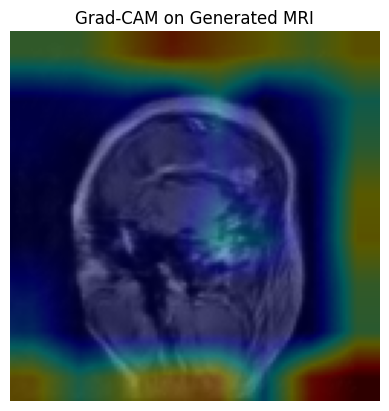

In [ ]:
def overlay_heatmap(img, cam, alpha=0.35):
    img = (img.squeeze().detach().cpu().numpy() + 1) / 2  # [-1,1] → [0,1]
    cam = cam.detach().cpu().numpy()

    cam = cv2.applyColorMap((cam * 255).astype("uint8"), cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB) / 255.0

    return (1 - alpha) * np.stack([img]*3, -1) + alpha * cam

img = samples[0].unsqueeze(0).to(device)
cam = compute_gradcam(D, img)
overlay = overlay_heatmap(img, cam)

plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM on Generated MRI")
plt.show()

## Final Comparison Panel

**Real vs Fake Comparison**

Grad-CAM visualizations show that the discriminator focuses on anatomically relevant regions in real MRI images, consistent with its behavior on generated samples.

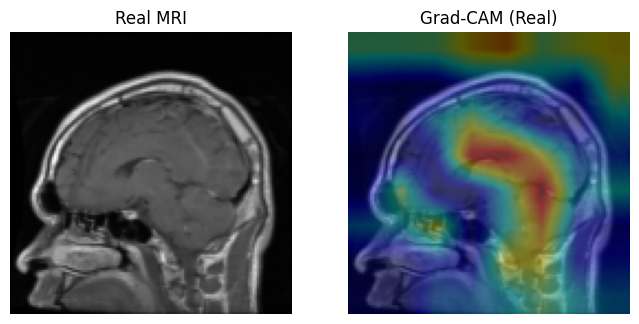

In [ ]:
real_img = dataset[0].unsqueeze(0).to(device)

heatmap_real = compute_gradcam(D, real_img)
overlay_real = overlay_heatmap(real_img, heatmap_real, alpha=0.35)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(real_img.squeeze().detach().cpu(), cmap="gray")
axs[0].set_title("Real MRI")
axs[0].axis("off")

axs[1].imshow(overlay_real)
axs[1].set_title("Grad-CAM (Real)")
axs[1].axis("off")

plt.show()

**Note: Red-Yellow indicates high importance areas while Blue indicates low importance areas**

Final Visualization

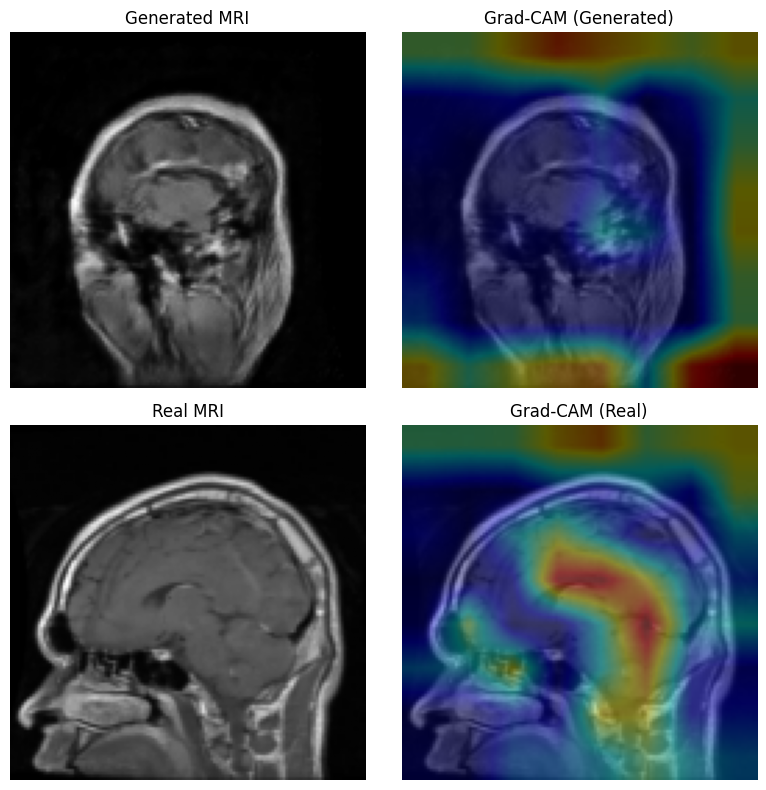

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(samples[0].squeeze(), cmap="gray")
axs[0, 0].set_title("Generated MRI")
axs[0, 0].axis("off")

axs[0, 1].imshow(overlay)
axs[0, 1].set_title("Grad-CAM (Generated)")
axs[0, 1].axis("off")

axs[1, 0].imshow(real_img.squeeze().detach().cpu(), cmap="gray")
axs[1, 0].set_title("Real MRI")
axs[1, 0].axis("off")

axs[1, 1].imshow(overlay_real)
axs[1, 1].set_title("Grad-CAM (Real)")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

## Conclusion

**Key Observations:**
- The generator produces anatomically coherent MRI images, capturing global head structure and realistic intensity distributions.
- Grad-CAM visualizations tells Discriminator focuses on anatomical regions rather than spurious artifacts (no shortcuts learned).
- To make the model more effective, we can use more complex discriminator architecture.

**Limitations:**
- Generated images are not intended for clinical diagnosis
- The model is trained on unconditional GAN 

